In [1]:
# Load used Python packages
import numpy as np
import pandas as pd
from SimPEG.utils import surface2ind_topo, model_builder
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from SimPEG.electromagnetics.static import resistivity as dc
from pymatsolver import Pardiso as Solver
import matplotlib.pyplot as plt
from pymatsolver import Pardiso

>> Use cython version


## Step1: Load ERT resistivity data

In [2]:
fnames = [
    './data/TN_DD_F0.csv',
    './data/TN_DD_F1.csv',
    './data/TN_DD_F2.csv',
    './data/TN_DD_F3.csv'
]

fname = fnames[0]
df = pd.read_csv(fname, encoding= 'unicode_escape')
n_data = df.shape[0]
data_io = dc.IO()
a = np.c_[df['xA (m)'].values, np.zeros(n_data)]
b = np.c_[df['xB (m)'].values, np.zeros(n_data)]
m = np.c_[df['xM (m)'].values, np.zeros(n_data)]
n = np.c_[df['xN (m)'].values, np.zeros(n_data)]
rho = df['Rho (Ohm.m)'].values # rho: apparent resistivity [ohm-m]
dev_rho = df['Dev. Rho (%)'].values # rho: apparent resistivity [ohm-m]
# create a survey object from the data_io object
survey = data_io.from_abmn_locations_to_survey(
    a, b, m, n, 
    survey_type='dipole-dipole', # don't be confused dipole-dipole includes any type of arrays using four electrodes system
    data_dc=rho, 
    data_dc_type='apparent_resistivity'# input data type
)
# plot ert data on a pseudo-section
# create a 2D tensor mesh
mesh, _ = data_io.set_mesh(dx=1, dz=1, corezlength=5, pad_rate_z=1.2, npad_z=10)

wires = maps.Wires(
    ('sigma_0', mesh.nC),
    ('sigma_1', mesh.nC),
    ('sigma_2', mesh.nC),
    ('sigma_3', mesh.nC)    
)

C:\Users\sgkan\Projects\simpeg\SimPEG\electromagnetics\static\resistivity\IODC.py:204: UserWarning: code under construction - API might change in the future
  warnings.warn("code under construction - API might change in the future")


In [3]:
wires.maps[0][1]

In [4]:
for ii, fname in enumerate(fnames):    
    df = pd.read_csv(fname, encoding= 'unicode_escape')
    n_data = df.shape[0]
    data_io = dc.IO()
    a = np.c_[df['xA (m)'].values, np.zeros(n_data)]
    b = np.c_[df['xB (m)'].values, np.zeros(n_data)]
    m = np.c_[df['xM (m)'].values, np.zeros(n_data)]
    n = np.c_[df['xN (m)'].values, np.zeros(n_data)]
    rho = df['Rho (Ohm.m)'].values # rho: apparent resistivity [ohm-m]
    dev_rho = df['Dev. Rho (%)'].values # rho: apparent resistivity [ohm-m]
    # create a survey object from the data_io object
    survey = data_io.from_abmn_locations_to_survey(
        a, b, m, n, 
        survey_type='dipole-dipole', # don't be confused dipole-dipole includes any type of arrays using four electrodes system
        data_dc=rho, 
        data_dc_type='apparent_resistivity'# input data type
    )

    # create a data object
    dc_data = data.Data(survey=survey, dobs=data_io.voltages)
    # assign data uncertainty or error (defined as standard deviation)
    standard_deviation = 0.03 * np.abs(dc_data.dobs) + 1e-3
    dc_data.standard_deviation = standard_deviation
    conductivity_map = maps.ExpMap(mesh) * wires.maps[ii][1]
    # create a simulation object
    simulation = dc.simulation_2d.Simulation2DNodal(
        mesh, survey=survey, sigmaMap=conductivity_map, storeJ=True, miniaturize=True
    )
    simulation.solver = Pardiso
    # create a data misfit object
    if ii == 0:
        dmis = data_misfit.L2DataMisfit(data=dc_data, simulation=simulation)
    else:
        dmis += data_misfit.L2DataMisfit(data=dc_data, simulation=simulation)

C:\Users\sgkan\Projects\simpeg\SimPEG\electromagnetics\static\resistivity\IODC.py:204: UserWarning: code under construction - API might change in the future
  warnings.warn("code under construction - API might change in the future")
C:\Users\sgkan\Projects\simpeg\SimPEG\electromagnetics\static\resistivity\IODC.py:204: UserWarning: code under construction - API might change in the future
  warnings.warn("code under construction - API might change in the future")
C:\Users\sgkan\Projects\simpeg\SimPEG\electromagnetics\static\resistivity\IODC.py:204: UserWarning: code under construction - API might change in the future
  warnings.warn("code under construction - API might change in the future")
C:\Users\sgkan\Projects\simpeg\SimPEG\electromagnetics\static\resistivity\IODC.py:204: UserWarning: code under construction - API might change in the future
  warnings.warn("code under construction - API might change in the future")


In [5]:
regs = []
norms = np.c_[0., 0., 0.]
for ii, fname in enumerate(fnames):
    regmap = wires.maps[ii][1]
    reg_tmp = regularization.Sparse(
        mesh,
        mapping=regmap,
        gradientType="total",
        alpha_s=1e-5,
        alpha_x=1,
        alpha_y=1,
    )
    reg_tmp.norms = norms
    regs.append(reg_tmp)

In [6]:
from discretize import TensorMesh

In [7]:
h_mesh = np.ones(mesh.nC)
h_time = np.ones(4)
mesh_time = TensorMesh([h_mesh, h_time])

In [8]:
regmap = maps.IdentityMap(mesh_time)
norms = np.c_[2., 0., 0.]
reg_time = regularization.Sparse(
        mesh_time,
        mapping=regmap,
        alpha_s=0,
        alpha_x=0,
        alpha_y=1,
)
reg_time.norms = norms

In [9]:
reg = regs[0] + regs[1] + regs[2] + regs[3] + reg_time

In [10]:
m0 = np.ones(mesh.n_cells*4) * np.log(1./100.)

In [11]:
# define how the optimization problem is solved. Here we will use an inexact
# Gauss-Newton approach.
opt = optimization.InexactGaussNewton(maxIter=40, maxIterCG=30)

# here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

#######################################################################
# define DC Inversion Directives
# ------------------------------
#
# here we define any directives that are carried out during the inversion. This
# includes the cooling schedule for the trade-off parameter (beta), stopping
# criteria for the inversion and saving inversion results at each iteration.
#

# reach target misfit for L2 solution, then use IRLS until model stops changing.
update_IRLS = directives.Update_IRLS(
    max_irls_iterations=25, minGNiter=1, chifact_start=1.0,
    f_min_change=1e-4, fix_Jmatrix=False
)

# defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
beta_schedule = directives.BetaSchedule(coolingFactor=2, coolingRate=1)

# Options for outputting recovered models and predicted data for each beta.
save_dict = directives.SaveOutputDictEveryIteration()
save_dict.outDict = {}
# Apply and update sensitivity weighting as the model updates
target = directives.TargetMisfit()
directives_list = [
    update_IRLS,
    starting_beta,
    save_dict,
#     beta_schedule,
#     target
]

#####################################################################
# Running the ERT Inversion
# ------------------------
#
# To define the inversion object, we need to define the inversion problem and
# the set of directives. We can then run the inversion.
#

# Here we combine the inverse problem and the set of directives
dc_inversion = inversion.BaseInversion(inv_prob, directiveList=directives_list)

# Run inversion
recovered_conductivity_model = dc_inversion.run(m0) 

C:\Users\sgkan\Projects\simpeg\SimPEG\directives\directives.py:1485: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `Directives.UpdatePreconditioner` to your directives list
  warnings.warn(


SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solver_opts as the Simulation2DNodal problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.20e+02  1.34e+06  0.00e+00  1.34e+06    7.99e+04      0              
   1  3.10e+02  1.71e+05  1.82e+01  1.77e+05    1.29e+04      0              
   2  1.55e+02  2.92e+04  6.39e+01  3.91e+04    1.92e+03      0   Skip BFGS  
   3  7.75e+01  1.34e+04  1.09e+02  2.19e+04    6.00e+02 

In [17]:
from matplotlib.colors import LogNorm
from discretize import utils as dis_utils
core_inds, mesh_core = dis_utils.extract_core_mesh(np.array([[0, 282], [-25, 0]]), mesh)

In [18]:
rhos = []
for map_tmp in wires.maps:
    rhos.append(1./np.exp(map_tmp[1] * recovered_conductivity_model))

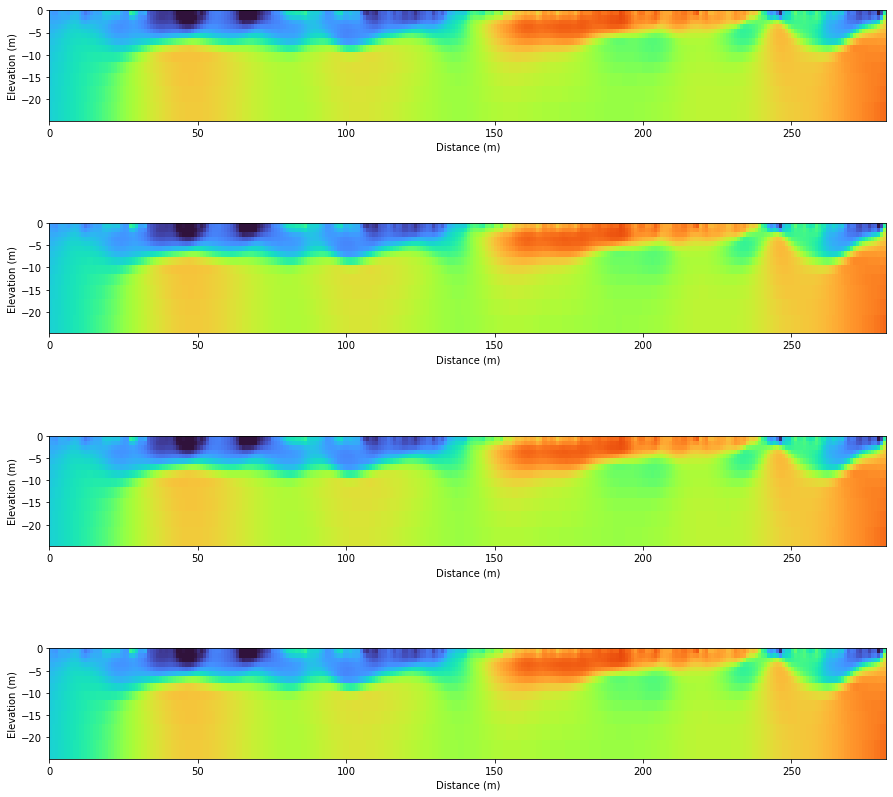

In [19]:
fig, axs = plt.subplots(4,1, figsize=(15, 15))
ii = 0
for ii, ax in enumerate(axs):
    res = rhos[ii]
    out = mesh_core.plot_image(res[core_inds], pcolor_opts={'norm': LogNorm(vmin=20, vmax=1000), 'cmap':'turbo'},ax=ax)
    ax.set_aspect(1.5)
#     cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.02, ax=ax)
#     cb.set_label("Resistivity ($\Omega$m)")
    ax.set_xlabel("Distance (m)")
    ax.set_ylabel("Elevation (m)")

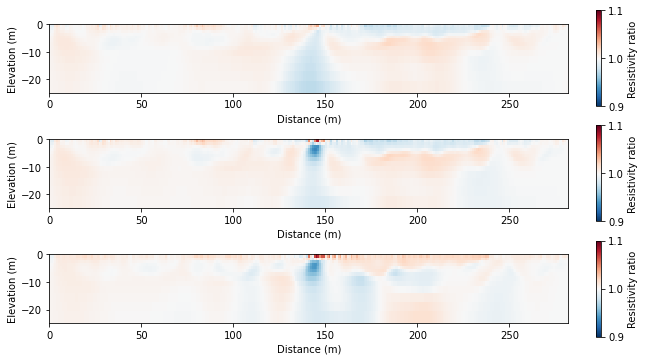

In [20]:
fig, axs = plt.subplots(3,1, figsize=(10, 6))
ii = 0
rho_0 = rhos[0]
for ii, ax in enumerate(axs):
    rho =rhos[ii+1]
    ratio = rho / rho_0
    out = mesh_core.plot_image(ratio[core_inds], pcolor_opts={'cmap':'RdBu_r'},ax=ax, clim=(0.9, 1.1))
    ax.set_aspect(1.5)
    cb = plt.colorbar(out[0], fraction=0.02, ax=ax)
    cb.set_label("Resistivity ratio")
    ax.set_xlabel("Distance (m)")
    ax.set_ylabel("Elevation (m)")
    ax.set_title("")

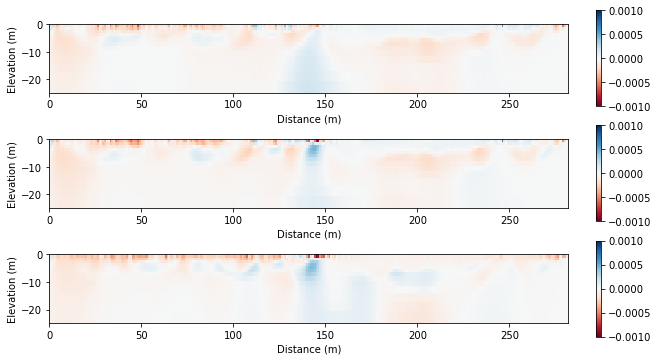

In [21]:
fig, axs = plt.subplots(3,1, figsize=(10, 6))
ii = 0
sigma_0 = 1./rhos[0]
for ii, ax in enumerate(axs):
    sigma = 1./rhos[ii+1]
    diff = sigma - sigma_0
    out = mesh_core.plot_image(diff[core_inds], pcolor_opts={'cmap':'RdBu'},ax=ax, clim=(-0.001, 0.001))
    ax.set_aspect(1.5)
    cb = plt.colorbar(out[0], fraction=0.02, ax=ax)
#     cb.set_label("Resistivity ($\Omega$m)")
    ax.set_xlabel("Distance (m)")
    ax.set_ylabel("Elevation (m)")
    ax.set_title("")